In [2]:
# Only install what might be missing on Colab
!pip install noisereduce --quiet


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import noisereduce as nr
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, GRU, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report


In [4]:
# Colab should have a GPU by default if you select Runtime > Change runtime type > GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Clone the Coswara dataset from GitHub
!git clone https://github.com/iiscleap/Coswara-Data.git /content/Coswara-Data


Cloning into '/content/Coswara-Data'...
remote: Enumerating objects: 995, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 995 (delta 58), reused 45 (delta 45), pack-reused 928 (from 3)
Receiving objects: 100% (995/995), 15.97 GiB | 17.55 MiB/s, done.
Resolving deltas: 100% (422/422), done.
Updating files: 100% (336/336), done.


In [6]:
import pandas as pd

# Load combined metadata CSV
metadata_path = '/content/Coswara-Data/combined_data.csv'
metadata = pd.read_csv(metadata_path)

# Quick look at first rows
metadata.head()


,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,...,vacc,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia
0,iV3Db6t1T8b7c5HQY2TwxIhjbzD3,28,healthy,2020-04-23,y,male,India,Anantapur,Andhra Pradesh,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AxuYWBN0jFVLINCBqIW5aZmGCdu1,25,healthy,2020-04-20,y,male,India,BENGALURU URBAN,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C5eIsssb9GSkaAgIfsHMHeR6fSh1,28,healthy,2020-04-24,y,female,United States,Pittsburgh,Pennsylvania,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YjbEAECMBIaZKyfqOvWy5DDImUb2,26,healthy,2020-04-23,y,male,India,Bangalore,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,32,healthy,2020-04-22,y,male,India,Nalanda,Bihar,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
%cd /content/Coswara-Data
!python extract_data.py


Streaming output truncated to the last 5000 lines.
20210630/gFmySpqfQ7YrYqMrmrMPO7AzmBm1/breathing-deep.wav
20210630/gFmySpqfQ7YrYqMrmrMPO7AzmBm1/metadata.json
20210630/gFmySpqfQ7YrYqMrmrMPO7AzmBm1/vowel-e.wav
20210630/gFmySpqfQ7YrYqMrmrMPO7AzmBm1/breathing-shallow.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/vowel-a.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/counting-normal.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/cough-heavy.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/counting-fast.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/cough-shallow.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/vowel-o.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/breathing-deep.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/metadata.json
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/vowel-e.wav
20210630/4ySGp3wKh0dbtEap33yRsDv3LE73/breathing-shallow.wav
20210630/YQzhlTCYjlgentYYTgVEDgNPapN2/
20210630/YQzhlTCYjlgentYYTgVEDgNPapN2/vowel-a.wav
20210630/YQzhlTCYjlgentYYTgVEDgNPapN2/counting-normal.wav
2

In [8]:
!mv /content/Coswara-Data/Extracted_data /content/


In [9]:
!rm -rf /content/Coswara-Data


In [10]:
%cd /content/Coswara-Data


[Errno 2] No such file or directory: '/content/Coswara-Data'
/content/Coswara-Data


In [11]:
DATA_PATH = '/content/Extracted_data'


In [12]:
!wget https://github.com/iiscleap/Coswara-Data/raw/main/combined_data.csv -O combined_data.csv


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
combined_data.csv: No such file or directory


In [15]:
from google.colab import files
import os

# Change the current working directory back to /content/
os.chdir('/content/')

uploaded = files.upload()  # then select the CSV

Saving combined_data.csv to combined_data.csv


In [16]:
import os
print("Current directory:", os.getcwd())
!ls -lh


Current directory: /content
total 360K
-rw-r--r--  1 root root 351K Oct 13 17:31 combined_data.csv
drwxr-xr-x 45 root root 4.0K Oct 13 17:27 Extracted_data
drwxr-xr-x  1 root root 4.0K Oct 10 13:36 sample_data


In [17]:
import pandas as pd

metadata = pd.read_csv("combined_data.csv")

# Filter for healthy or COVID-positive participants
covid_positive_status = ['positive_moderate', 'positive_mild', 'positive_asymp']
healthy_status = ['healthy']

metadata_filtered = metadata[metadata['covid_status'].isin(covid_positive_status + healthy_status)].copy()

# Create binary labels
metadata_filtered['label'] = metadata_filtered['covid_status'].apply(lambda x: 1 if x in covid_positive_status else 0)

# Check distribution
print(metadata_filtered['label'].value_counts())


label
0    1433
1     681
Name: count, dtype: int64


In [18]:
import os

sample_path = '/content/Extracted_data/20200413/0Rlzhiz6bybk77wdLjxwy7yLDhg1'
print("Files in participant folder:")
print(os.listdir(sample_path))


Files in participant folder:
['breathing-deep.wav', 'counting-fast.wav', 'metadata.json', 'counting-normal.wav', 'vowel-o.wav', 'vowel-a.wav', 'cough-heavy.wav', 'cough-shallow.wav', 'breathing-shallow.wav', 'vowel-e.wav']


In [19]:
import json
import os

# Example participant folder
participant_folder = "/content/Extracted_data/20200413/0Rlzhiz6bybk77wdLjxwy7yLDhg1"
metadata_file = os.path.join(participant_folder, "metadata.json")

# Read JSON
with open(metadata_file, "r") as f:
    participant_metadata = json.load(f)

# Inspect content
print(json.dumps(participant_metadata, indent=4))


{
    "id": "0Rlzhiz6bybk77wdLjxwy7yLDhg1",
    "a": 37,
    "covid_status": "no_resp_illness_exposed",
    "iF": true,
    "ep": "y",
    "g": "male",
    "l_s": "Maharashtra",
    "dT": "web",
    "l_c": "India"
}


In [20]:
import pandas as pd

metadata = pd.read_csv("combined_data.csv")


In [21]:
# 0 = healthy, 1 = any non-healthy
metadata['label'] = metadata['covid_status'].apply(lambda x: 0 if x.lower() == 'healthy' else 1)

# Check distribution
print(metadata['label'].value_counts())
print(metadata['covid_status'].value_counts())


label
0    1433
1    1313
Name: count, dtype: int64
covid_status
healthy                        1433
positive_mild                   426
no_resp_illness_exposed         248
positive_moderate               165
resp_illness_not_identified     157
recovered_full                  146
positive_asymp                   90
under_validation                 81
Name: count, dtype: int64


In [22]:
metadata.shape


(2746, 37)

In [23]:
metadata['covid_status'].value_counts()


,count
covid_status,
healthy,1433
positive_mild,426
no_resp_illness_exposed,248
positive_moderate,165
resp_illness_not_identified,157
recovered_full,146
positive_asymp,90
under_validation,81


In [24]:
import os

def get_cough_paths(row):
    folder = os.path.join("/content/Extracted_data", str(row['record_date']).replace('-', ''), row['id'])
    files = ["cough-shallow.wav", "cough-heavy.wav"]
    return [os.path.join(folder, f) for f in files if os.path.exists(os.path.join(folder, f))]

metadata['cough_files'] = metadata.apply(get_cough_paths, axis=1)


In [25]:
metadata.shape

(2746, 38)

In [26]:
import os
import glob
import pandas as pd

data_root = "/content/Extracted_data"
metadata = pd.read_csv("combined_data.csv")

# Make a list of cough recordings for each participant
cough_files_list = []

for pid in metadata['id']:
    participant_folder = os.path.join(data_root, "*", pid)  # wildcard for date folders
    folders = glob.glob(participant_folder)

    cough_paths = []
    for folder in folders:
        for f in ["cough-shallow.wav", "cough-heavy.wav"]:
            path = os.path.join(folder, f)
            if os.path.exists(path):
                cough_paths.append(path)

    cough_files_list.append(cough_paths)

metadata['cough_files'] = cough_files_list

# Filter participants with at least one cough recording
metadata = metadata[metadata['cough_files'].map(len) > 0]


In [27]:
metadata.shape


(2746, 37)

In [28]:
metadata['covid_status'].value_counts()


,count
covid_status,
healthy,1433
positive_mild,426
no_resp_illness_exposed,248
positive_moderate,165
resp_illness_not_identified,157
recovered_full,146
positive_asymp,90
under_validation,81


In [29]:
# Number of participants with at least one cough recording
num_with_cough = (metadata['cough_files'].map(len) > 0).sum()
print(f"Participants with cough recordings: {num_with_cough}")

# Total participants
total = len(metadata)
print(f"Total participants: {total}")

# Fraction
print(f"Fraction with cough recordings: {num_with_cough/total:.2%}")
# Count number of cough files per participant
metadata['num_cough_files'] = metadata['cough_files'].map(len)

# Distribution of number of cough files
cough_count_distribution = metadata['num_cough_files'].value_counts().sort_index()
print(cough_count_distribution)



Participants with cough recordings: 2746
Total participants: 2746
Fraction with cough recordings: 100.00%
num_cough_files
1       1
2    2745
Name: count, dtype: int64


In [30]:
metadata = metadata[metadata['num_cough_files'] > 1]


In [32]:
metadata.shape

(2745, 38)

In [31]:
import glob
import os

def get_cough_files(participant_id):
    # This finds the exact folder for the participant
    folders = glob.glob(f"/content/Extracted_data/*/{participant_id}")
    files = []
    if folders:  # folder exists
        folder = folders[0]  # take the first match
        for f in os.listdir(folder):
            if "cough" in f:
                files.append(os.path.join(folder, f))
    return files

metadata['cough_files'] = metadata['id'].apply(get_cough_files)


In [33]:
metadata.shape

(2745, 38)

In [35]:
# List all column names
print(metadata.columns)


Index(['id', 'a', 'covid_status', 'record_date', 'ep', 'g', 'l_c', 'l_l',
       'l_s', 'rU', 'smoker', 'cold', 'ht', 'diabetes', 'cough', 'ctDate',
       'ctScan', 'ctScore', 'diarrhoea', 'fever', 'loss_of_smell', 'mp',
       'testType', 'test_date', 'test_status', 'um', 'vacc', 'bd',
       'others_resp', 'ftg', 'st', 'ihd', 'asthma', 'others_preexist', 'cld',
       'pneumonia', 'cough_files', 'num_cough_files'],
      dtype='object')


In [36]:
# Map covid_status to binary labels
metadata['label'] = metadata['covid_status'].apply(lambda x: 0 if x == 'healthy' else 1)

# Quick check
metadata[['covid_status', 'label']].head()


,covid_status,label
0,healthy,0
1,healthy,0
2,healthy,0
3,healthy,0
4,healthy,0


In [37]:
import librosa
import numpy as np
from tqdm import tqdm

all_features = []
all_labels = []

def extract_features(audio_paths, label):
    features = []
    labels = []
    for file_path in audio_paths:
        try:
            signal, sr = librosa.load(file_path, sr=22050)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            features.append(log_mel_spec)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return features, labels

for idx, row in tqdm(metadata.iterrows(), total=metadata.shape[0], desc="Extracting features"):
    files = row['cough_files']
    lbl = row['label']  # 0 or 1
    feats, labs = extract_features(files, lbl)
    all_features.extend(feats)
    all_labels.extend(labs)

print(f"Total spectrograms extracted: {len(all_features)}")


Extracting features:   1%|▏         | 39/2745 [00:14<03:15, 13.83it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting features:  21%|██▏       | 588/2745 [00:35<01:14, 28.76it/s]/tmp/ipython-input-277499336.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting features:  22%|██▏       | 591/2745 [00:36<01:41, 21.25it/s]

Error processing /content/Extracted_data/20200820/5q8gLM0yCrgGCT8F9fWlH4ycl1D3/._cough-heavy.wav: 


Extracting features:  23%|██▎       | 631/2745 [00:37<01:16, 27.60it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting features:  92%|█████████▏| 2514/2745 [02:02<00:07, 30.46it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1882
  warnings.warn(
Extracting features: 100%|██████████| 2745/2745 [02:12<00:00, 20.65it/s]

Total spectrograms extracted: 5490


In [42]:
import librosa
import numpy as np
from tqdm import tqdm
#updated feature extraction with MFCC, mel-spectrograms, pitch, energy, zero-crossing rate,spectral features
def extract_features(audio_paths, label):
    features = []
    labels = []

    for file_path in audio_paths:
        try:
            signal, sr = librosa.load(file_path, sr=22050)

            if len(signal) == 0:
                 print(f"Warning: Empty signal for {file_path}. Skipping.")
                 continue

            # Pad or trim to 3 seconds for uniformity
            target_length = sr * 3
            signal = librosa.util.fix_length(signal, size=target_length)

            # --- Core Features ---
            log_mel_spec = None
            mfcc = None
            rms = None
            zcr = None
            spec_centroid = None
            spec_bw = None
            spec_contrast = None
            pitch_mean = None

            try:
                # 1. Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # 2. MFCC
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

                # 3. Energy (RMS)
                rms = librosa.feature.rms(y=signal)

                # 4. Zero Crossing Rate
                zcr = librosa.feature.zero_crossing_rate(y=signal)

                # 5. Spectral features
                spec_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
                spec_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)

                # 6. Pitch (Fundamental Frequency)
                pitches, magnitudes = librosa.piptrack(y=signal, sr=sr)
                pitch_values = pitches[magnitudes > np.median(magnitudes)]
                pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0.0

            except Exception as e:
                print(f"Error extracting features for {file_path}: {e}")
                continue # Skip this file if feature extraction fails


            # --- Combine into one feature vector ---
            # Ensure all features were successfully extracted and have the same number of frames before stacking
            if log_mel_spec is not None and mfcc is not None and rms is not None and zcr is not None and \
               spec_centroid is not None and spec_bw is not None and spec_contrast is not None:

                min_frames = min(log_mel_spec.shape[1], mfcc.shape[1], rms.shape[1], zcr.shape[1],
                                 spec_centroid.shape[1], spec_bw.shape[1], spec_contrast.shape[1])


                combined = np.vstack([
                    log_mel_spec[:, :min_frames],
                    mfcc[:, :min_frames],
                    rms[:, :min_frames],
                    zcr[:, :min_frames],
                    spec_centroid[:, :min_frames],
                    spec_bw[:, :min_frames],
                    spec_contrast[:, :min_frames]
                ])


                # Normalize
                combined = (combined - np.min(combined)) / (np.max(combined) - np.min(combined) + 1e-6)

                # Append features and labels only if feature extraction was successful and combined is not empty
                if combined.size > 0:
                    features.append(combined)
                    labels.append(label)
                else:
                    print(f"Warning: Combined features are empty for {file_path}. Skipping.")
            else:
                 print(f"Warning: Some features were not extracted for {file_path}. Skipping.")


        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Optionally, log the error and the file path to a file for later inspection


    return features, labels


# --- Extract features for all files ---
all_features = []
all_labels = []

for idx, row in tqdm(metadata.iterrows(), total=metadata.shape[0], desc="Extracting features"):
    files = row['cough_files']
    lbl = row['label']  # 0 or 1
    feats, labs = extract_features(files, lbl)
    all_features.extend(feats)
    all_labels.extend(labs)

print(f"Total features extracted: {len(all_features)}")

Extracting features:   1%|▏         | 41/2745 [00:05<06:43,  6.70it/s]

Extracting features:   4%|▍         | 120/2745 [00:13<03:42, 11.81it/s]

Extracting features:   8%|▊         | 224/2745 [00:24<03:35, 11.68it/s]

Extracting features:  10%|▉         | 266/2745 [00:28<03:32, 11.65it/s]

Extracting features:  12%|█▏        | 333/2745 [00:36<03:21, 11.95it/s]

Extracting features:  14%|█▎        | 376/2745 [00:40<03:20, 11.84it/s]

Extracting features:  17%|█▋        | 473/2745 [00:51<03:06, 12.17it/s]

Extracting features:  18%|█▊        | 487/2745 [00:53<03:08, 11.99it/s]

Extracting features:  18%|█▊        | 496/2745 [00:54<03:01, 12.38it/s]

Extracting features:  19%|█▊        | 511/2745 [00:55<03:56,  9.43it/s]

Extracting features:  19%|█▉        | 531/2745 [00:58<03:32, 10.40it/s]

Extracting features:  21%|██▏       | 585/2745 [01:04<03:59,  9.03it/s]

Extracting features:  21%|██▏       | 588/2745 [01:04<04:55,  7.29it/s]/tmp/ipython-input-2084407989.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /content/Extracted_data/20200820/5q8gLM0yCrgGCT8F9fWlH4ycl1D3/._cough-heavy.wav: 


Extracting features:  23%|██▎       | 634/2745 [01:11<04:20,  8.10it/s]

Extracting features:  25%|██▍       | 679/2745 [01:15<03:04, 11.18it/s]

Extracting features:  38%|███▊      | 1036/2745 [01:56<02:25, 11.74it/s]

Extracting features:  42%|████▏     | 1166/2745 [02:10<02:16, 11.59it/s]

Extracting features:  43%|████▎     | 1170/2745 [02:11<02:03, 12.78it/s]

Extracting features:  43%|████▎     | 1194/2745 [02:13<02:11, 11.84it/s]

Extracting features:  47%|████▋     | 1285/2745 [02:23<02:01, 12.06it/s]

Extracting features:  53%|█████▎    | 1463/2745 [02:44<02:25,  8.80it/s]

Extracting features:  54%|█████▍    | 1496/2745 [02:47<01:56, 10.70it/s]

Extracting features:  62%|██████▏   | 1694/2745 [03:10<02:20,  7.50it/s]

Extracting features:  62%|██████▏   | 1704/2745 [03:11<01:37, 10.71it/s]

Extracting features:  64%|██████▍   | 1762/2745 [03:17<01:23, 11.78it/s]

Extracting features:  68%|██████▊   | 1860/2745 [03:28<01:19, 11.14it/s]

Extracting features:  68%|██████▊   | 1870/2745 [03:29<01:18, 11.17it/s]

Extracting features:  68%|██████▊   | 1874/2745 [03:29<01:12, 12.06it/s]

Extracting features:  69%|██████▉   | 1890/2745 [03:31<01:22, 10.41it/s]

Extracting features:  69%|██████▉   | 1898/2745 [03:32<01:19, 10.64it/s]

Extracting features:  73%|███████▎  | 2015/2745 [03:44<01:01, 11.96it/s]

Extracting features:  74%|███████▍  | 2042/2745 [03:48<01:50,  6.37it/s]

Extracting features:  75%|███████▍  | 2049/2745 [03:49<01:32,  7.53it/s]

Extracting features:  75%|███████▌  | 2066/2745 [03:51<00:56, 12.00it/s]

Extracting features:  76%|███████▌  | 2088/2745 [03:53<00:54, 11.99it/s]

Extracting features:  77%|███████▋  | 2125/2745 [03:56<00:53, 11.50it/s]

Extracting features:  78%|███████▊  | 2135/2745 [03:57<00:49, 12.21it/s]

Extracting features:  80%|███████▉  | 2189/2745 [04:04<00:50, 11.08it/s]

Extracting features:  80%|████████  | 2205/2745 [04:06<00:50, 10.77it/s]

Extracting features:  82%|████████▏ | 2255/2745 [04:11<00:46, 10.60it/s]

Extracting features:  87%|████████▋ | 2399/2745 [04:29<00:40,  8.49it/s]

Extracting features:  88%|████████▊ | 2403/2745 [04:29<00:30, 11.07it/s]

Extracting features:  88%|████████▊ | 2409/2745 [04:29<00:27, 12.15it/s]

Extracting features:  90%|████████▉ | 2457/2745 [04:34<00:23, 12.19it/s]

Extracting features:  90%|████████▉ | 2459/2745 [04:34<00:20, 13.87it/s]

Extracting features:  92%|█████████▏| 2531/2745 [04:43<00:19, 10.98it/s]

Extracting features:  96%|█████████▌| 2629/2745 [04:54<00:20,  5.80it/s]

Extracting features: 100%|█████████▉| 2743/2745 [05:07<00:00,  6.19it/s]

Extracting features: 100%|██████████| 2745/2745 [05:07<00:00,  8.91it/s]

Total features extracted: 5407


In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# 1. Standardize spectrogram widths
# ------------------------------
# Find a suitable width (95th percentile)
spec_widths = [spec.shape[1] for spec in all_features]
TARGET_LEN = int(np.percentile(spec_widths, 95))
print(f"Target spectrogram width: {TARGET_LEN}")

def standardize_spectrogram(spec, target_len):
    """Pad or truncate a spectrogram to a fixed width."""
    current_len = spec.shape[1]
    if current_len > target_len:
        return spec[:, :target_len]
    elif current_len < target_len:
        pad_width = target_len - current_len
        return np.pad(spec, ((0,0),(0,pad_width)), mode='constant')
    else:
        return spec

# Apply standardization
X = np.array([standardize_spectrogram(s, TARGET_LEN) for s in all_features])
y = np.array(all_labels)

# Add channel dimension for CNN
X = X[..., np.newaxis]
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# ------------------------------
# 2. Train/Test split with stratification
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ------------------------------
# 3. Normalize spectrograms to [0,1]
# ------------------------------
scaler = MinMaxScaler()

# Reshape to 2D for scaler: (samples, height*width)
train_shape = X_train.shape
test_shape = X_test.shape

X_train_reshaped = X_train.reshape(train_shape[0], -1)
X_test_reshaped = X_test.reshape(test_shape[0], -1)

# Fit scaler on training data only
scaler.fit(X_train_reshaped)

# Transform both train and test
X_train_scaled = scaler.transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original 4D format
X_train = X_train_scaled.reshape(train_shape)
X_test = X_test_scaled.reshape(test_shape)

print(f"Data ready for CNN:")
print(f"X_train: {X_train.shape}, min={X_train.min():.2f}, max={X_train.max():.2f}")
print(f"X_test: {X_test.shape}, min={X_test.min():.2f}, max={X_test.max():.2f}")


Target spectrogram width: 130
Feature matrix shape: (5407, 152, 130, 1)
Label vector shape: (5407,)
Training samples: 4325, Testing samples: 1082
Data ready for CNN:
X_train: (4325, 152, 130, 1), min=0.00, max=1.00
X_test: (1082, 152, 130, 1), min=-0.00, max=1.17


In [45]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(152, 130, 1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5293 - loss: 0.6930 - val_accuracy: 0.5896 - val_loss: 0.6808
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5705 - loss: 0.6823 - val_accuracy: 0.6248 - val_loss: 0.6767
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5814 - loss: 0.6776 - val_accuracy: 0.6257 - val_loss: 0.6673
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5827 - loss: 0.6765 - val_accuracy: 0.6035 - val_loss: 0.6642
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5971 - loss: 0.6721 - val_accuracy: 0.6303 - val_loss: 0.6593
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6077 - loss: 0.6638 - val_accuracy: 0.6165 - val_loss: 0.6591
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6100 - loss: 0.6645 - val_accuracy: 0.6386 - val_loss: 0.6520
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6117 - loss: 0.6635 - val_acc

In [46]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6415 - loss: 0.6359 - val_accuracy: 0.6442 - val_loss: 0.6432
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6394 - loss: 0.6346 - val_accuracy: 0.6433 - val_loss: 0.6375
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6510 - loss: 0.6283 - val_accuracy: 0.6553 - val_loss: 0.6388
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6463 - loss: 0.6273 - val_accuracy: 0.6525 - val_loss: 0.6392
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6578 - loss: 0.6258 - val_accuracy: 0.6405 - val_loss: 0.6424
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6496 - loss: 0.6306 - val_accuracy: 0.6386 - val_loss: 0.6388
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6575 - loss: 0.6198 - val_accuracy: 0.5896 - val_loss: 0.6605
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6521 - loss: 0.6277 - val_accu

In [47]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6812 - loss: 0.6245
Test Accuracy: 66.08%
Test Loss: 0.6389


In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate specificity for binary classification
# Confusion matrix layout: [[TN, FP], [FN, TP]]
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
print(f"Specificity: {specificity:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[474  88]
 [279 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       562
           1       0.73      0.46      0.57       520

    accuracy                           0.66      1082
   macro avg       0.68      0.65      0.64      1082
weighted avg       0.68      0.66      0.65      1082

Specificity: 0.8434


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AUC-ROC: 0.6871


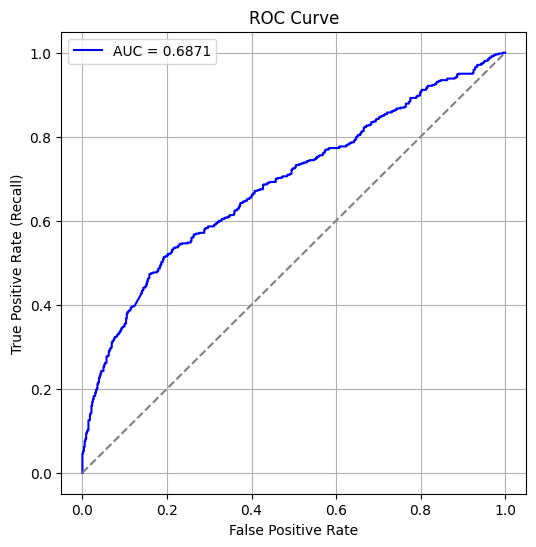

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs = model.predict(X_test).ravel()  # shape (num_samples,)

# Compute AUC-ROC
auc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc:.4f}")

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
